In [1]:
######################################################
######### Method: SLR + Additive Wht Noise  ##########
######################################################
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from netCDF4 import Dataset
import sys
sys.path.append("/glade/u/home/zhixing/Course_Studies/APPM/Project/codes/LR+AdditiveNoise/")
from functionsLR_AddNoise import *
from scipy import fftpack
from datetime import datetime
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
# np.random.seed(42)

In [2]:
print('Number of cores:', multiprocessing.cpu_count())
num_cores = 72

# Define other parameters of the problem
n_pc = 150         # number of PCs
n_record = 50000   # total records
n_maxtrain = 40000 # maximum possible length of training data
n_test = n_record - n_maxtrain # length of the test data
test0_idx = 40000              # test data start index
dt = 10            # temporal resolution

#### Load the pcs ####
f = 'psi1_DG_0_500K_100days_filtered_150PCs.dat'
# fpath = os.getcwd() + '/' + f
fpath = "/glade/u/home/zhixing/Course_Studies/APPM/Project/" + f
pcs = dlmread(fpath,n_record,n_pc)   ## (50000, 150)
pcs = center(pcs)  ## centralized data
# get the test dataset
test_data = pcs[test0_idx:test0_idx+n_test, :]  ## Truncate data from 40000 to 50000
 
#### Load the EOFs ####
nx = 513; ny=513
f = 'psi1_DG_0_500K_100days_filtered_150EOFs.nc'
eoffile = "/glade/u/home/zhixing/Course_Studies/APPM/Project/" + f
# eoffile = os.getcwd() + '/' + f
fid = Dataset(eoffile,'r')
eofs = fid.variables['EOFs'][:n_pc,:,:]
eofs = eofs.reshape((n_pc, nx*ny))  ## reshape into two dimensions (150, 513*513)

# train the LR
n_train = n_maxtrain # Length used for training (40000)
[x_train, y_train, scaler] = training4tendency(pcs, n_pc, n_train, dt, 'standard')  
# x_train: the rescaled training data (39999, 150), y_train: the derivative of time (39999, 150)
[linregmodel, reg_res, r2_sco] = linear_regression(x_train,y_train)
# linregmodel: linear regression model after feeding training data (already fit); reg_res: residual of regressions

# plot LR output vs the truth
y_tend_LR = linregmodel.predict(x_train)

Number of cores: 72


In [3]:
######### Calculation of decorrelation time for each PC #########
num_lags = 1200
tau = np.zeros((n_pc,))

start = datetime.now()

for k in range(n_pc):
    autocor_x = tsaplots.acf(x_train[:,k], nlags=num_lags, fft=False)
    # Autocorrelation, sometimes known as serial correlation in the discrete time case, is the correlation of a signal with a delayed copy of itself as a function of delay.
    tau[k] = np.where(autocor_x<1/np.exp(1))[0][0]

tau = tau*dt
print('Time taken = ',datetime.now()-start)
print(tau)

############### Red and White noise definitions #################

def l2_norm(array):
    return np.sqrt(np.sum(np.power(array,2)))

# Red Noise
def corrRedNoise(n_samples, n_in_param, residual, tau, deltaT):
    """ Red noise is a signal that has a gradual decrease in power as frequency increases """
    eta = np.zeros((n_samples, n_in_param))
    
    ## compute std of the white noise
    var_res = np.var(residual, axis=0)
    gamma = 1/tau 
    c = (1 - gamma*deltaT)
    sigma = np.sqrt(var_res*(1 - c**2)/(deltaT**2))
    
    # generate white noise and spinup the red noise system to draw 
    # samples from the correct distribution
    n_spin = 500000
    eta_ = np.zeros((n_spin, n_in_param))
    for i in range(1,n_spin):
        zeta_ = sigma*np.random.randn(1, n_in_param)
        eta_[i,:] = c*eta_[i-1,:] + deltaT*zeta_
        
    # compare the std of eta_ with that of the residuals
    std_diff = np.sqrt(var_res) - np.std(eta_, axis=0)
    print('L2 norm of the error in std(red noise):', l2_norm(std_diff))
    
    eta[0,:] = eta_[-1,:]
    for i in range(1, n_samples): 
        zeta = sigma*np.random.randn(1, n_in_param)
        eta[i,:] = c*eta[i-1,:] + deltaT*zeta
    
    covn = np.corrcoef(residual.T) # Correlation coefficients
    rr = np.linalg.cholesky(covn)
    
    return eta.dot(rr.T)

# Correlated white noise
def corrWhtNoise(nx, ny, residual):
    """White noise is a signal that has equal power across all frequencies and is completely random in nature.
    In other words, the amplitude of the signal is the same at all frequencies and there is no correlation between successive samples of the signal"""
    dW = np.random.randn(nx, ny) # additive white noise
    covn = np.corrcoef(residual.T) # Correlation coefficients
    rr = np.linalg.cholesky(covn)
    stdres = np.std(residual, axis=0)
    return dW.dot(rr.T)*stdres

Time taken =  0:01:18.476719
[1010.  410.  280.  280.   90.  110.  210.  100.  120.  340.  110.   80.
  270.  140.  100.  160.   80.  100.   90.  280.  220.  280.  110.   90.
   80.  100.   90.   90.   90.   90.   90.  120.  150.  100.  140.   90.
  100.  130.  110.   90.   90.  130.   90.  100.  110.  100.  110.  100.
  140.   90.   90.   90.  100.  100.   90.  110.  100.  100.  100.  100.
   90.  110.   90.  100.  100.  110.  100.  100.  110.  100.   90.  100.
  100.   90.   90.   90.  100.  100.   90.  110.   90.  110.   90.   90.
   90.   90.   90.   90.   90.  100.   80.  100.   90.   90.   80.  100.
   90.   90.  100.   90.   90.   80.   90.   90.   80.   90.  100.   90.
   80.   90.   90.   90.   90.   90.   80.   80.   90.   90.   80.   90.
  100.   90.   90.   90.   80.  100.   90.   90.   90.   80.   90.   80.
   90.   80.   90.   90.   90.   80.   90.   90.   80.   90.   80.  100.
   90.   90.   80.   80.   80.   80.]


In [4]:
####################################################################
##################### Short term forecasts #########################
####################################################################
n_maxlead = 10  # maximum lead time for the forecasts
n_ic = int((n_test - n_maxlead))    # Number of initial conditions 
n_ensem = 100   # Number of stochastic ensembles for each I.C.
y_pred = np.zeros([n_ic, n_ensem, n_maxlead, n_pc])
noisetype = 'white'

start = datetime.now()

# generate noise
if noisetype=='white':
    dW = corrWhtNoise(n_ic*n_maxlead*n_ensem, n_pc, reg_res)
elif noisetype=='red':
    dW = corrRedNoise(n_ic*n_maxlead*n_ensem, n_pc, reg_res, tau, dt)
else:
    raise ValueError('noise type not supported')
        
for i in range(n_ic):
    # initial condition
    x_start = test_data[i,:]
    y_pred[i,:,:,:] = forecast(n_ensem, n_maxlead, n_pc, x_start,
                               dt, linregmodel, scaler, 
                               dW[i*n_maxlead*n_ensem:(i+1)*n_maxlead*n_ensem])
    
# Ensemble mean for each IC
enMean_y_pred = np.mean(y_pred, axis=1)

print('Prediction time:', datetime.now()-start)
print('Number of initial conditions:', n_ic)
print('Number of ensembles per initial condition:', n_ensem)
print('Length of each forecast:', n_maxlead)

Prediction time: 0:17:34.486992
Number of initial conditions: 9990
Number of ensembles per initial condition: 100
Length of each forecast: 10


100%|██████████| 9990/9990 [02:35<00:00, 64.16it/s]


Time taken: 0:02:36.867794
shape of rmse: (9990, 10)


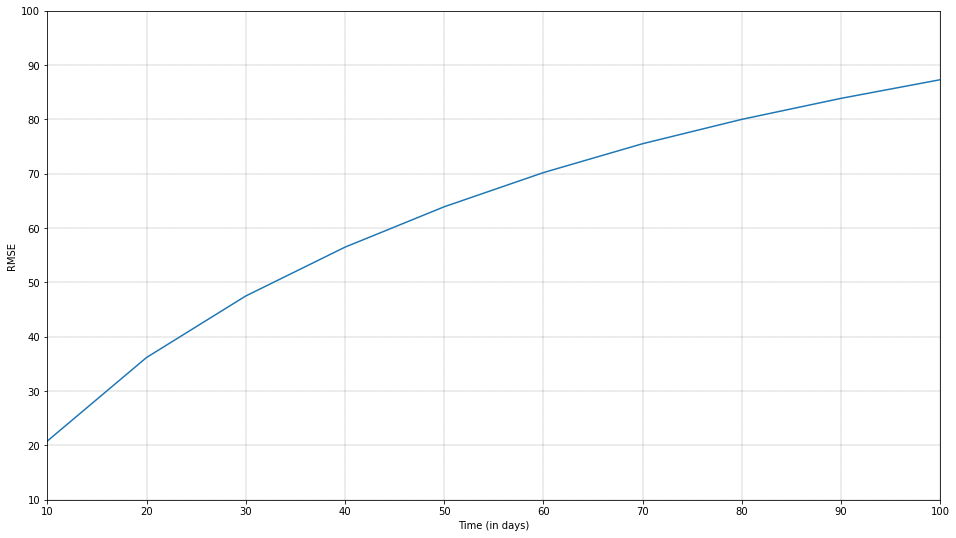

In [12]:
####################################################################
############ Metric 1 : RMSE on the physical space #################
###### Use each data point of the test dataset as an IC ############
## Obtain 100 stochastic realizations (if applicable) for each IC ##
####################################################################
# Project the modelled PCs onto the EOFs and calculate mean RMSE
rmse = np.zeros((n_ic, n_maxlead))

start = datetime.now()
# start a parallel pool and implement thread parallelism
if __name__ == "__main__":
    rmse = Parallel(n_jobs=num_cores, prefer="threads")(delayed(RMSE)(i,test_data,enMean_y_pred,eofs,n_maxlead) for i in tqdm(range(n_ic)))
print('Time taken:',datetime.now()-start)
rmse = np.array(rmse)
print("shape of rmse:", rmse.shape)
meanRMSE = np.mean(rmse, axis=0)
# np.save('RMSE_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K',meanRMSE)

# Plot the mean RMSE
fig, ax = plt.subplots(figsize = (16,9))

ax.plot(np.arange(dt,n_maxlead*dt+1,dt),meanRMSE)
ax.set_xlabel('Time (in days)')
ax.set_ylabel('RMSE')
ax.set_ylim([10, 100])
ax.set_xlim([dt, n_maxlead*dt])
ax.grid(color='k', linestyle='--', linewidth=0.2)
#plt.savefig('RMSE_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K.png',dpi=100)
#plt.close()
del rmse

100%|██████████| 9990/9990 [05:08<00:00, 32.36it/s]


Time taken: 0:05:13.334341
shape of itcc: (9990, 263169)


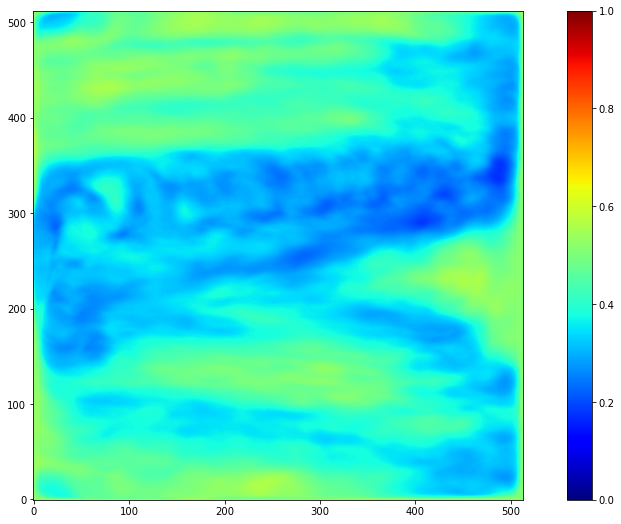

In [20]:
#####################################################################
# Metric 2a : Instantaneous temporal correlation coefficient (ITCC) #
#####################################################################
itcc = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    itcc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,enMean_y_pred,eofs,n_maxlead,'temporal') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
itcc = np.array(itcc)
print('shape of itcc:',itcc.shape)
meanitcc = np.mean(itcc, axis=0)

fig, ax = plt.subplots(figsize = (16,9))

im = ax.imshow(meanitcc.reshape(nx,ny), origin='lower', cmap='jet')
cb = plt.colorbar(im)
im.set_clim([0, 1])
# plt.savefig('ITCC_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K.png',dpi=100)
# plt.close()
# np.save('ITCC_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K',meanitcc)
del itcc

100%|██████████| 9990/9990 [04:15<00:00, 39.10it/s]


Time taken: 0:04:17.554239
shape of iscc: (9990, 10)


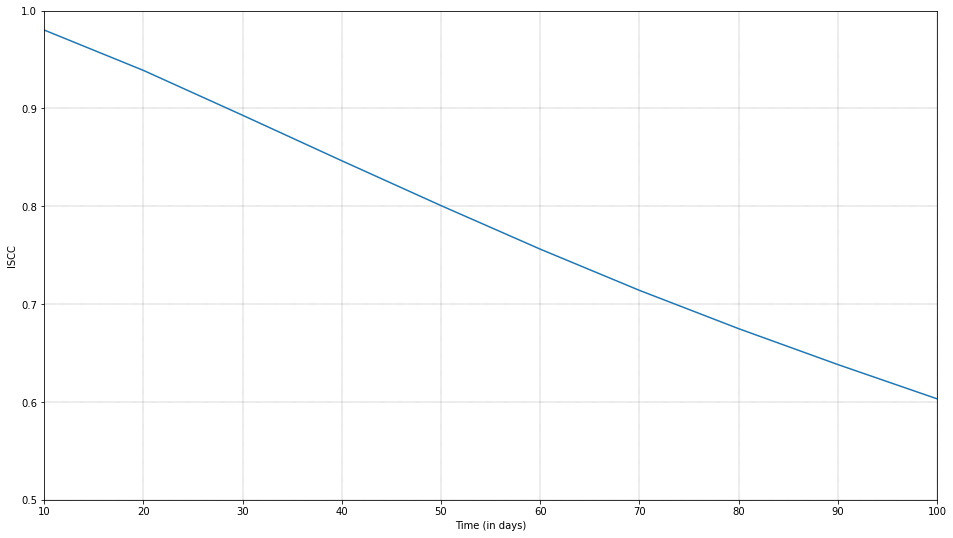

In [21]:
####################################################################
# Metric 2b : Instantaneous spatial correlation coefficient (ISCC) #
####################################################################
iscc = np.zeros((n_ic, n_maxlead))

start = datetime.now()
if __name__ == "__main__":
    iscc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,enMean_y_pred,eofs,n_maxlead,'spatial') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
iscc = np.array(iscc)
print('shape of iscc:',iscc.shape)

meaniscc = np.mean(iscc, axis=0)

fig, ax = plt.subplots(figsize = (16,9))

ax.plot(np.arange(dt,n_maxlead*dt+1,dt), meaniscc)
ax.set_xlabel('Time (in days)')
ax.set_ylabel('ISCC')
ax.set_xlim([dt, n_maxlead*dt])
ax.set_ylim([0.5, 1])
ax.grid(color='k', linestyle='--', linewidth=0.2)

#plt.savefig('ISCC_Psi1_50days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_ntrain=400K_ntest=100K.png',dpi=100)
# plt.close()
# np.save('ISCC_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K',meaniscc)
del iscc

In [22]:
################################################################
#################### Long term forecasts #######################
################################################################
n_maxlead = 20000  # maximum lead time for the forecasts
n_ic = 1    # Number of initial conditions 
n_ensem = 1   # Number of stochastic ensembles for each I.C.
y_pred = np.zeros([n_ic, n_ensem, n_maxlead, n_pc])
noisetype = 'white'
    
start = datetime.now()

# generate noise
if noisetype=='white':
    dW = corrWhtNoise(n_ic*n_maxlead*n_ensem, n_pc, reg_res)
elif noisetype=='red':
    dW = corrRedNoise(n_ic*n_maxlead*n_ensem, n_pc, reg_res, tau, dt)
else:
    raise ValueError('noise type not supported')
    
for k in range(n_ic):
    #### Start Forecasts ####
    x_start = test_data[k,:]
    
    y_pred[k,:,:,:] = forecast(n_ensem, n_maxlead, n_pc, x_start,
                               dt, linregmodel, scaler, 
                               dW[k*n_maxlead*n_ensem:(k+1)*n_maxlead*n_ensem])

# Ensemble mean for each IC
enMean_y_pred = np.mean(y_pred, axis=1)

print('Prediction time:', datetime.now()-start)
print('Number of initial conditions:',n_ic)
print('Number of ensembles per initial condition:',n_ensem)
print('Length of each forecast:',n_maxlead)


Prediction time: 0:00:02.611727
Number of initial conditions: 1
Number of ensembles per initial condition: 1
Length of each forecast: 20000


In [23]:
################################################################
##### Metric 3-5 : Climatology, Variance, and Frequency map ####
############### using long time scale forecasts  ###############
############ frequency = 1/decorrelation time ##################
################################################################
psi1_climatology_pred = np.zeros((n_ic,nx*ny))
psi1_variance_pred = np.zeros((n_ic,nx*ny))
freq_pred = np.zeros((n_ic,nx*ny))
mean_tmp = np.zeros((nx*ny))
var_tmp = np.zeros((nx*ny))

# Project the modelled PCs onto the EOFs and calculate climatology
for kk in range(n_ic):
    psi1_pred = enMean_y_pred[kk,:,:].dot(eofs)
    mean_tmp, var_tmp = mean_and_variance(psi1_pred)
    psi1_climatology_pred[kk,:] = mean_tmp
    psi1_variance_pred[kk,:] = var_tmp
    if __name__ == "__main__":
        freq_ = Parallel(n_jobs=num_cores, prefer="threads")(delayed(frequency)(i,psi1_pred,dt) for i in tqdm(range(nx*ny)))
    freq_pred[kk,:] = freq_

mean_psi1_climatology_pred = np.mean(psi1_climatology_pred, axis=0)
mean_psi1_variance_pred = np.mean(psi1_variance_pred, axis=0)
mean_freq_pred = np.mean(freq_pred, axis=0)
del psi1_pred


100%|██████████| 263169/263169 [14:40<00:00, 298.91it/s]


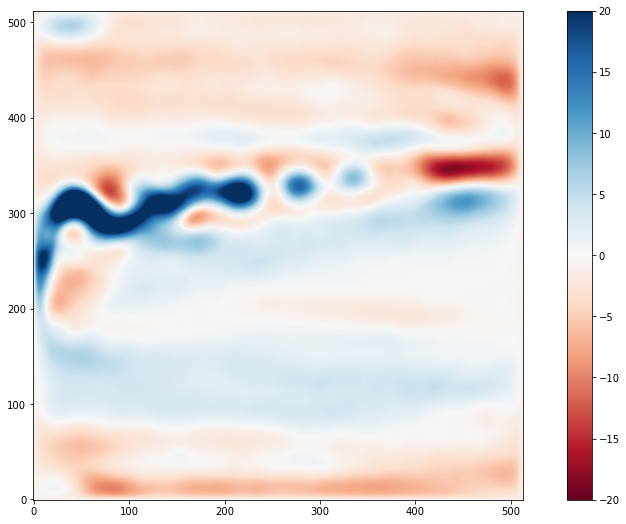

In [25]:
# Climatology and variance of the predictions
fig, ax = plt.subplots(figsize = (16,9))

im = ax.imshow(mean_psi1_climatology_pred.reshape(nx,ny), origin='lower', cmap='RdBu')
im.set_clim(-20, 20)
plt.colorbar(im)
# plt.savefig('Climatology_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K.png',dpi=100)
# plt.close()
# np.save('Climatology_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K',mean_psi1_climatology_pred)


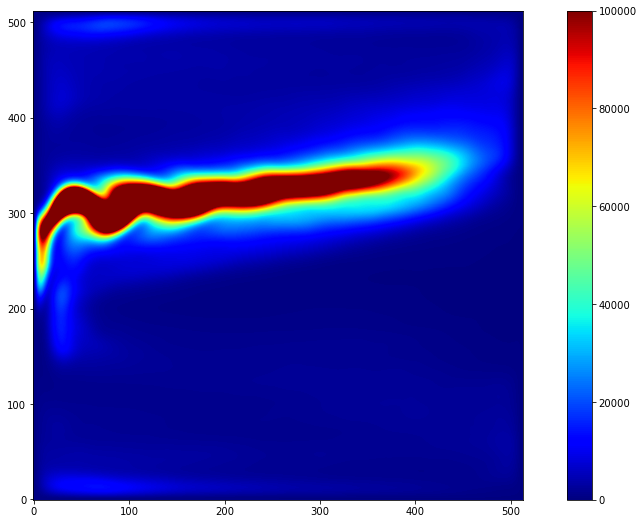

In [26]:
fig, ax = plt.subplots(figsize = (16,9))

im = ax.imshow(mean_psi1_variance_pred.reshape(nx,ny), origin='lower', cmap='jet')
im.set_clim(0, 100000)
plt.colorbar(im)
# plt.savefig('Variance_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K.png',dpi=100)
# plt.close()
# np.save('Variance_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K',mean_psi1_variance_pred)


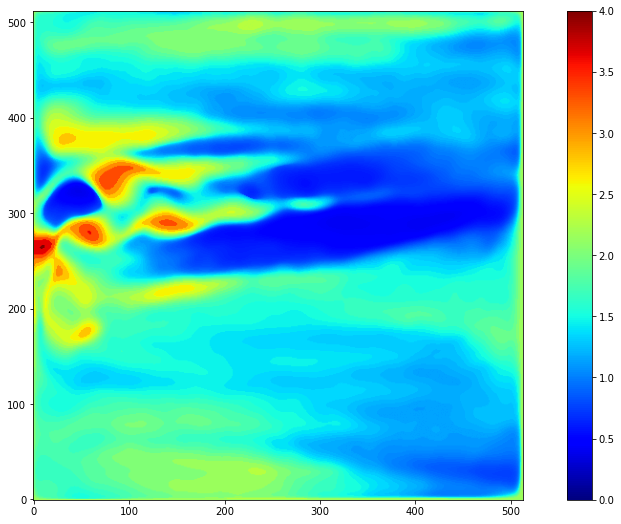

In [27]:
# Frequency map of the predictions
fig, ax = plt.subplots(figsize = (16,9))

im = ax.imshow(np.array(mean_freq_pred).reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar(im)
im.set_clim([0,4])
# plt.savefig('Frequency_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K.png',dpi=300)
# plt.close()
# np.save('Frequency_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K',mean_freq_pred)

In [2]:
%%time

"""
####################################################################
##################### Short term forecasts #########################
####################################################################
n_maxlead = 10  # maximum lead time for the forecasts
n_ic = int((n_test - n_maxlead))    # Number of initial conditions 
n_ensem = 100   # Number of stochastic ensembles for each I.C.
y_pred = np.zeros([n_ic, n_ensem, n_maxlead, n_pc])
noisetype = 'white'

start = datetime.now()

# generate noise
if noisetype=='white':
    dW = corrWhtNoise(n_ic*n_maxlead*n_ensem, n_pc, reg_res)
elif noisetype=='red':
    dW = corrRedNoise(n_ic*n_maxlead*n_ensem, n_pc, reg_res, tau, dt)
else:
    raise ValueError('noise type not supported')
        
for i in range(n_ic):
    # initial condition
    x_start = test_data[i,:]
    y_pred[i,:,:,:] = forecast(n_ensem, n_maxlead, n_pc, x_start,
                               dt, linregmodel, scaler, 
                               dW[i*n_maxlead*n_ensem:(i+1)*n_maxlead*n_ensem])
    
# Ensemble mean for each IC
enMean_y_pred = np.mean(y_pred, axis=1)

print('Prediction time:', datetime.now()-start)
print('Number of initial conditions:', n_ic)
print('Number of ensembles per initial condition:', n_ensem)
print('Length of each forecast:', n_maxlead)

####################################################################
############ Metric 1 : RMSE on the physical space #################
###### Use each data point of the test dataset as an IC ############
## Obtain 100 stochastic realizations (if applicable) for each IC ##
####################################################################
# Project the modelled PCs onto the EOFs and calculate mean RMSE
rmse = np.zeros((n_ic, n_maxlead))

start = datetime.now()
# start a parallel pool and implement thread parallelism
if __name__ == "__main__":
    rmse = Parallel(n_jobs=num_cores, prefer="threads")(delayed(RMSE)(i,test_data,enMean_y_pred,eofs,n_maxlead) for i in tqdm(range(n_ic)))

meanRMSE = np.mean(rmse, axis=0)
np.save('RMSE_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K',meanRMSE)

# Plot the mean RMSE
#plt.plot(np.arange(dt,n_maxlead*dt+1,dt),meanRMSE)
#plt.xlabel('Time (in days)')
#plt.ylabel('RMSE')
#plt.ylim([10, 80])
#plt.xlim([dt, n_maxlead*dt])
#plt.grid(color='k', linestyle='--', linewidth=0.2)
#plt.savefig('RMSE_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K.png',dpi=100)
#plt.close()
del rmse
#####################################################################
# Metric 2a : Instantaneous temporal correlation coefficient (ITCC) #
#####################################################################
itcc = np.zeros((n_ic, nx*ny))

start = datetime.now()
if __name__ == "__main__":
    itcc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,enMean_y_pred,eofs,n_maxlead,'temporal') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)

meanitcc = np.mean(itcc, axis=0)

plt.imshow(meanitcc.reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim([0, 1])
plt.savefig('ITCC_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K.png',dpi=100)
plt.close()
np.save('ITCC_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K',meanitcc)
del itcc
####################################################################
# Metric 2b : Instantaneous spatial correlation coefficient (ISCC) #
####################################################################
iscc = np.zeros((n_ic, n_maxlead))

start = datetime.now()
if __name__ == "__main__":
    iscc = Parallel(n_jobs=num_cores, prefer="threads")(delayed(ICC_wrapper)(i,test_data,enMean_y_pred,eofs,n_maxlead,'spatial') for i in tqdm(range(n_ic)))

print('Time taken:',datetime.now()-start)
meaniscc = np.mean(iscc, axis=0)

#plt.plot(np.arange(dt,n_maxlead*dt+1,dt), meaniscc)
#plt.xlabel('Time (in days)')
#plt.ylabel('ISCC')
#plt.xlim([dt, n_maxlead*dt])
#plt.ylim([0.7, 1])
#plt.grid(color='k', linestyle='--', linewidth=0.2)
#plt.savefig('ISCC_Psi1_50days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_ntrain=400K_ntest=100K.png',dpi=100)
#plt.close()
np.save('ISCC_Psi1_100days_predictions_AddWhtNoise_npc=150_norm=own_nic=9990_nensem=100_ntrain=400K_ntest=100K',meaniscc)
del iscc
"""
################################################################
#################### Long term forecasts #######################
################################################################
n_maxlead = 20000  # maximum lead time for the forecasts
n_ic = 1    # Number of initial conditions 
n_ensem = 1   # Number of stochastic ensembles for each I.C.
y_pred = np.zeros([n_ic, n_ensem, n_maxlead, n_pc])
noisetype = 'white'
    
start = datetime.now()

# generate noise
if noisetype=='white':
    dW = corrWhtNoise(n_ic*n_maxlead*n_ensem, n_pc, reg_res)
elif noisetype=='red':
    dW = corrRedNoise(n_ic*n_maxlead*n_ensem, n_pc, reg_res, tau, dt)
else:
    raise ValueError('noise type not supported')
    
for k in range(n_ic):
    #### Start Forecasts ####
    x_start = test_data[k,:]
    
    y_pred[k,:,:,:] = forecast(n_ensem, n_maxlead, n_pc, x_start,
                               dt, linregmodel, scaler, 
                               dW[k*n_maxlead*n_ensem:(k+1)*n_maxlead*n_ensem])

# Ensemble mean for each IC
enMean_y_pred = np.mean(y_pred, axis=1)

print('Prediction time:', datetime.now()-start)
print('Number of initial conditions:',n_ic)
print('Number of ensembles per initial condition:',n_ensem)
print('Length of each forecast:',n_maxlead)

################################################################
##### Metric 3-5 : Climatology, Variance, and Frequency map ####
############### using long time scale forecasts  ###############
############ frequency = 1/decorrelation time ##################
################################################################
psi1_climatology_pred = np.zeros((n_ic,nx*ny))
psi1_variance_pred = np.zeros((n_ic,nx*ny))
freq_pred = np.zeros((n_ic,nx*ny))
mean_tmp = np.zeros((nx*ny))
var_tmp = np.zeros((nx*ny))

# Project the modelled PCs onto the EOFs and calculate climatology
for kk in range(n_ic):
    psi1_pred = enMean_y_pred[kk,:,:].dot(eofs)
    mean_tmp, var_tmp = mean_and_variance(psi1_pred)
    psi1_climatology_pred[kk,:] = mean_tmp
    psi1_variance_pred[kk,:] = var_tmp
    if __name__ == "__main__":
        freq_ = Parallel(n_jobs=num_cores, prefer="threads")(delayed(frequency)(i,psi1_pred,dt) for i in tqdm(range(nx*ny)))
    freq_pred[kk,:] = freq_

mean_psi1_climatology_pred = np.mean(psi1_climatology_pred, axis=0)
mean_psi1_variance_pred = np.mean(psi1_variance_pred, axis=0)
mean_freq_pred = np.mean(freq_pred, axis=0)
del psi1_pred
"""
# Climatology and variance of the predictions
plt.imshow(mean_psi1_climatology_pred.reshape(nx,ny), origin='lower', cmap='RdBu')
plt.clim(-20, 20)
plt.colorbar()
plt.savefig('Climatology_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.close()
np.save('Climatology_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K',mean_psi1_climatology_pred)

plt.imshow(mean_psi1_variance_pred.reshape(nx,ny), origin='lower', cmap='jet')
plt.clim(0, 100000)
plt.colorbar()
plt.savefig('Variance_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.close()
np.save('Variance_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K',mean_psi1_variance_pred)
"""
# Frequency map of the predictions
plt.imshow(np.array(mean_freq_pred).reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim([0,4])
# plt.savefig('Frequency_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K.png',dpi=300)
plt.close()
# np.save('Frequency_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K',mean_freq_pred)


Number of cores: 72
Time taken =  0:01:22.515939
[1010.  410.  280.  280.   90.  110.  210.  100.  120.  340.  110.   80.
  270.  140.  100.  160.   80.  100.   90.  280.  220.  280.  110.   90.
   80.  100.   90.   90.   90.   90.   90.  120.  150.  100.  140.   90.
  100.  130.  110.   90.   90.  130.   90.  100.  110.  100.  110.  100.
  140.   90.   90.   90.  100.  100.   90.  110.  100.  100.  100.  100.
   90.  110.   90.  100.  100.  110.  100.  100.  110.  100.   90.  100.
  100.   90.   90.   90.  100.  100.   90.  110.   90.  110.   90.   90.
   90.   90.   90.   90.   90.  100.   80.  100.   90.   90.   80.  100.
   90.   90.  100.   90.   90.   80.   90.   90.   80.   90.  100.   90.
   80.   90.   90.   90.   90.   90.   80.   80.   90.   90.   80.   90.
  100.   90.   90.   90.   80.  100.   90.   90.   90.   80.   90.   80.
   90.   80.   90.   90.   90.   80.   90.   90.   80.   90.   80.  100.
   90.   90.   80.   80.   80.   80.]
Prediction time: 0:00:02.249577
Numbe

100%|██████████| 263169/263169 [14:50<00:00, 295.51it/s]


CPU times: user 17h 51min 50s, sys: 52.8 s, total: 17h 52min 43s
Wall time: 18min 29s


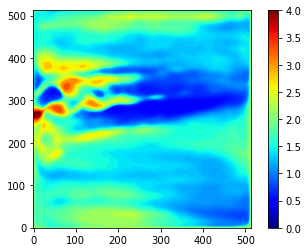

In [13]:
mean_psi1_climatology_pred = np.mean(psi1_climatology_pred, axis=0)
mean_psi1_variance_pred = np.mean(psi1_variance_pred, axis=0)
mean_freq_pred = np.mean(freq_pred, axis=0)
# del psi1_pred
"""
# Climatology and variance of the predictions
plt.imshow(mean_psi1_climatology_pred.reshape(nx,ny), origin='lower', cmap='RdBu')
plt.clim(-20, 20)
plt.colorbar()
plt.savefig('Climatology_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.close()
np.save('Climatology_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K',mean_psi1_climatology_pred)

plt.imshow(mean_psi1_variance_pred.reshape(nx,ny), origin='lower', cmap='jet')
plt.clim(0, 100000)
plt.colorbar()
plt.savefig('Variance_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K.png',dpi=100)
plt.close()
np.save('Variance_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K',mean_psi1_variance_pred)
"""
# Frequency map of the predictions
plt.imshow(np.array(mean_freq_pred).reshape(nx,ny), origin='lower', cmap='jet')
plt.colorbar()
plt.clim([0,4])
# plt.savefig('Frequency_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K.png',dpi=300)
# plt.close()
# np.save('Frequency_Psi1_200Kdays_predictions_AddWhtNoise_npc=150_norm=own_nic=1_nensem=1_ntrain=400K_ntest=100K',mean_freq_pred)